# LCNN(Light Convolutional Neural Network)
Front-end are LFCC, CQCC.<br>LCNN is adopted to perform back-end.

### Aim
>1. Edit pytorch dataset Done
>2. Code LCNN architecture
>3. Build LCNN model
>4. Test

In [57]:
# Library for dataloader
import os.path
import glob
from hdf5storage import loadmat

# Feature extraction
import librosa
import soundfile as sf
import numpy as np
import pandas as pd
import joblib

# Library for pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

# Configuration
import random

In [10]:
# Set fixed random seed
# Setting random seeds for reproducibility.
seed = 120
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True # CUDA determinism 

device = torch.device("cuda" if cuda.is_available() else "cpu")
model.to(device)

NameError: name 'cuda' is not defined

In [12]:
float_formatter = "{:.4f}".format

np.set_printoptions(formatter={'float_kind': float_formatter})

In [167]:
def make_datapath_list(phase, feature_type):
    """
    make a list containing a path to data
    
    Parameters
    ----------
    phase: 'train' or 'dev' or 'eval'
        specify whether data is for train or development or evaluation
    
    Returns
    ----------
    path_list : list
        return a list containing a path to data
    """
    
    if feature_type in ['CQT','LFCC','CQCC']:
        root_path = "/home/s1260057/workspace/GT/ASV_anti-spoofing/datasets/"
        target_path = os.path.join(root_path, phase, feature_type, '*')
    
    elif feature_type in ['SPEC','FFT']:
        root_path = "/DB/Audio/English/ASVspoof2019/LA/"
        target_path = os.path.join(root_path, 'ASVspoof2019_LA_'+phase+'/flac/*')
        
    else:
        print('[Error: None of feature_types were matched.]')
        raise AttributeError
    
    print(target_path)
    
    path_list = []
    
    # Get a filepath to subdir by using glob module
    for path in sorted(glob.glob(target_path)):
        path_list.append(path)
    
    return path_list

# test
train_list = make_datapath_list(phase='train', feature_type='FFT')
dev_list = make_datapath_list(phase='dev', feature_type='LFCC')

print(len(train_list), len(dev_list))

/DB/Audio/English/ASVspoof2019/LA/ASVspoof2019_LA_train/flac/*
/home/s1260057/workspace/GT/ASV_anti-spoofing/datasets/dev/LFCC/*
25380 24844


In [38]:
class Preprocess(object):
    """
    Preprocessing class for audio data
    
    Attributes:
    
    """
    def __init__(self, shape):
        """
        Parameters
        ----------
        
        """
        self.shape = shape
        
    def __call__(self, d):
        """
        Extract fetures with lfcc, mfcc, cqcc and other method
        
        Parameters
        ----------
        
        """
        n = self.shape[0] - d.shape[0]
        # Cropping or truncation process might be inserted here, return fixed length feature matrix
        if n <= 0:
            x = self.padding(d, n)
        else:
            x = self.truncate(d, n)
            
        return x
    
    def padding(self, x, n):
        # Pad x to be n matrix
        return x
    
    def truncate(self, x, n):
        # Truncate x to be n matrix
        return x
    

In [39]:
class FeatureExtractor(object):
    """
    FeatureExtractor class for audio data
    
    Attributes:
    
    """
    def __init__(self, feature_type):
        """
        Parameters
        ----------
        
        """
        self.extractor = None
        self.feature_type = feature_type
        
    def __call__(self, y, sr, dynamic=True):
        """
        Extract fetures such as fft, spectrogram and other methods
        
        Parameters
        ----------
        
        """
        if self.feature_type == 'LFCC':
            self.extractor = LFCC(y, sr)
            
        elif self.feature_type == 'MFCC':
            self.extractor = MFCC(y, sr)
        
        elif self.feature_type == 'CQCC':
            self.extractor = CQCC(y, sr)
        
        elif self.feature_type == 'FFT':
            self.extractor = FFT(y, sr)
        
        elif self.feature_type == 'SPEC':
            self.extractor = SPEC(y, sr)
            
        else:
            print('Wrong feature extraction method specified')
            raise AttributeError
        
        if dynamic:
            features = self.extractor.extract_feature(delta=True)
        else:
            features = self.extractor.extract_feature()
        
        return features

In [174]:
# Make dataloader
class ASVspoofDataSet(data.Dataset):
    """
    Dataset class for ASVspoof2019, which derived from torch.utils.data.Dataset class
    
    Attributes:
    --------------
    file_list: list
        list containing a path to data
        
    transform: object
        instance of PreProcessor
    
    phase: str
        'train' or 'dev' or 'eval'
    """
    
    def __init__(self, file_list, phase, feature_type, preprocess=None, extractor=None, detailed_label=False):
        """
        Parameters
        ----------
        file_list: list
            list of audio files to read
        
        label_list: list
            list of labels('bonafide' or 'spoof'), which is changed to 0, 1
        
        transform: class PreProcess
            instance of PreProcess to be used for pre-process to audio data
        
        phase: str
            specify whether data is for training or development or evaluation('train' or 'dev' or 'eval')
            
        """
        self.file_list = file_list
        self.phase = phase
        self.feature_type = feature_type
        self.preprocess = preprocess
        self.feature_extract = extractor
        self.detailed_label = detailed_label
        
        if self.detailed_label:
            
            self.root_path = '/DB/Audio/English/ASVspoof2019/LA/ASVspoof2019_LA_cm_protocols/'
            
            if self.phase == 'train':
                self.label_path = os.path.join(self.root_path, 'ASVspoof2019.LA.cm.train.trn.txt')
                self.label_list = []
                with open(self.label_path, mode='r') as protocols:
                    for line in protocols:
                        line = line.split() # read line by line
                        filename, label = line[1], line[-1] # get filename and label from protocols file
                        self.label_list.append((filename, label))
            
            elif self.phase == 'dev':
                self.label_path = os.path.join(self.root_path, 'ASVspoof2019.LA.cm.dev.trl.txt')
                self.label_list = []
                with open(self.label_path, mode='r') as protocols:
                    for line in protocols:
                        line = line.split() # read line by line
                        filename, label = line[1], (line[0], line[3], line[-1]) # get items from protocols file
                        self.label_list.append((filename, label))
            else:
                print("You must pass either phase='train' or phase='dev'")
        
    def __len__(self): # this is needed to be overrided
        return len(self.file_list)
    
    def __getitem__(self, index): # this is also needed to be overrided
        """
        Get preprocessed data and its label
        """
        if self.feature_type in ['CQT','LFCC','CQCC']:
            # load feature matrix
            #print( type(loadmat(self.file_list[index])['x_fea']) ) => ndarray
            features = loadmat(self.file_list[index])['x_fea']
            label = self.file_list[index].split('_')[-1].rstrip('.mat')
            
        elif self.feature_type in ['SPEC','FFT']:
            # load audio
            speech_path = self.file_list[index]
            speech, sr = sf.read(speech_path)
            
            ###
            return speech, sr
            features = self.extractor(y=speech, sr=sr)
            
            label = None
            speech_name = speech_path.split('/')[-1].rstrip('.flac')
            
            for fname, key in self.label_list:
                if fname == speech_name: # compare to speech_name with '==' annotation, check if they have same value.
                    label = key
                    print("filename: {}, label: {}".format(fname, label))
            if label is None:
                print('[debug print] non label filename:', speech_name)

        else:
            print('[Error: None of feature_types were matched.]')
            raise AttributeError
            
        # preprocessing and extract features
        features = self.preprocess(d=features)
        #print(type(features))
        tensor = torch.from_numpy(features).float()
        #print(type(tensor))
        
        return tensor, label

# Test

feature_type = 'FFT'

train_list = make_datapath_list(phase='train', feature_type=feature_type)
print(len(train_list))

process = Preprocess(shape=(864, 400, 3))

extractor = FeatureExtractor(feature_type=feature_type)

asvspoof_train = ASVspoofDataSet(file_list=train_list, phase='train', feature_type=feature_type, preprocess=process, extractor=extractor)

# Get 10 files and their label
iterations = 10

for itr in range(iterations):
    #print(asvspoof_train.file_list[itr])
    feature, label = asvspoof_train.__getitem__(itr)
    print("60 vectors", feature.T.shape)
    print("audiofile label: ", label)
    print()

/DB/Audio/English/ASVspoof2019/LA/ASVspoof2019_LA_train/flac/*
25380
60 vectors (40006,)
audiofile label:  16000

60 vectors (45608,)
audiofile label:  16000

60 vectors (30753,)
audiofile label:  16000

60 vectors (36346,)
audiofile label:  16000

60 vectors (60233,)
audiofile label:  16000

60 vectors (53220,)
audiofile label:  16000

60 vectors (45848,)
audiofile label:  16000

60 vectors (37098,)
audiofile label:  16000

60 vectors (31687,)
audiofile label:  16000

60 vectors (28891,)
audiofile label:  16000



In [234]:
import scipy.signal as signal
import matplotlib.pyplot as plt

x, fs = sf.read('LA_T_1028533.flac')
print(x.shape)

(29219,)


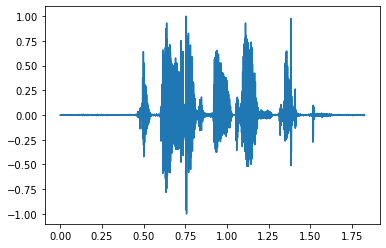

In [259]:
xx = np.arange(0, len(x))/sr

plt.plot(xx, x)

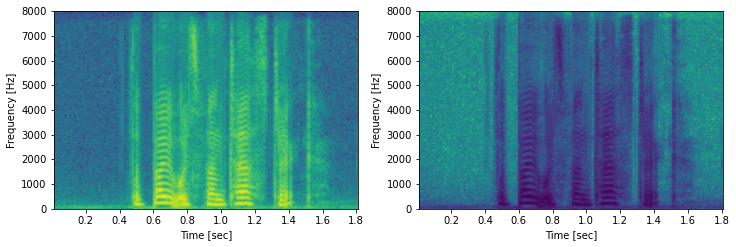

In [260]:
f1, t1, Sxx1 = signal.spectrogram(x, fs, window=np.hamming(320), nperseg=320, noverlap=320//2, nfft=512, mode='magnitude')

f2, t2, Sxx2 = signal.spectrogram(x, fs, window=np.hamming(320), nperseg=320, noverlap=320//2, nfft=512, mode='magnitude')

fig = plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.pcolormesh(t1, f1, np.log10(Sxx1), shading='gouraud')
plt.xlabel('Time [sec]')
plt.ylabel('Frequency [Hz]')

plt.subplot(222)
plt.pcolormesh(t2, f2, np.log10(Sxx2)**2, shading='gouraud')
plt.xlabel('Time [sec]')
plt.ylabel('Frequency [Hz]')

plt.show()

In [261]:
print(len(x)/16000)
print(Sxx1.shape)
print(Sxx2.shape)

1.8261875
(257, 181)
(257, 181)


In [262]:
y = librosa.core.stft(x, win_length=320, hop_length=320//2, n_fft=512, window=np.hamming(320), center=False)

y.shape

(257, 180)

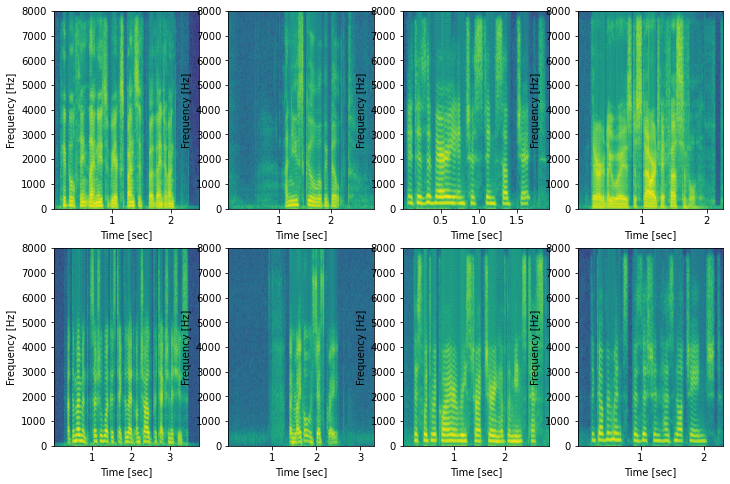

In [213]:

fig = plt.figure(figsize=(12, 8))

iterations = 8
for itr in range(iterations):
    
    x, sr = asvspoof_train.__getitem__(itr)
    
    f1, t1, Sxx1 = signal.spectrogram(x, sr, window=win, nperseg=320, noverlap=512//2, nfft=512, mode='magnitude')

    plt.subplot(2, 4, itr+1)
    plt.pcolormesh(t1, f1, np.log10(Sxx1), shading='gouraud')
    plt.xlabel('Time [sec]')
    plt.ylabel('Frequency [Hz]')

plt.show()

In [215]:
import librosa
import librosa.display
import librosa.core

Text(0.5, 1.0, 'Log-frequency power spectrogram')

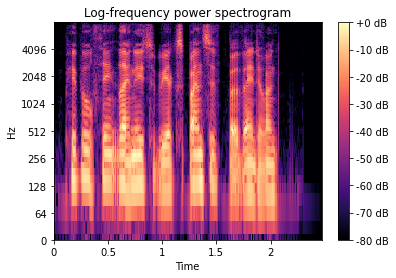

In [208]:
x, sr = asvspoof_train.__getitem__(0)

D = librosa.amplitude_to_db(np.abs(librosa.core.stft(x, win_length=320, hop_length=160, n_fft=512, window=np.hamming(320), center=False)), ref=np.max)

librosa.display.specshow(D, sr=sr, hop_length=160, x_axis='time', y_axis='log')

plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

In [45]:
# Development dataset for validation

feature_type = 'LFCC'
process = Preprocess(shape=(864, 400, 3))
extractor = FeatureExtractor(feature_type=feature_type)

asvspoof_dev = ASVspoofDataSet(file_list=dev_list, phase='dev', feature_type=feature_type, preprocess=process, extractor=extractor)

# get 10 files and its label
iterations = 10

for itr in range(iterations):
    feature, label = asvspoof_dev.__getitem__(itr)
    #print("60 vectors", feature.T.shape)
    print("audiofile label:", label)

audiofile label: spoof
audiofile label: spoof
audiofile label: spoof
audiofile label: spoof
audiofile label: spoof
audiofile label: spoof
audiofile label: spoof
audiofile label: spoof
audiofile label: spoof
audiofile label: spoof


In [ ]:
#dev_path = '/DB/Audio/English/ASVspoof2019/LA/ASVspoof2019_LA_dev/flac/*'

cm_LA_LFCC = []

for i, file in enumerate(glob.glob('../ASVspoof_2019_baseline_CM_v1/dev_dataset/*')):
    
    features = hdf5storage.loadmat(file)['x_fea']
    
    label = file.split('_')[-1].rstrip('.mat')
    
    #print(features.shape, label)
    
    feature_tensor = torch.from_numpy(features.T).float()
    
    # compute log-likelihood ratio
    score = -(gmm_bonafide.evaluate(feature_tensor) - gmm_spoof.evaluate(feature_tensor))
    
    cm_LA_LFCC.append((label, score))
    
print('Done!')
print(len(cm_LA_LFCC)) # This should be 24844

In [ ]:
# This is for evaluation of score with 3-labels
with open('./scores/scores_cm_LA_LFCC_torch_itr10_sentence_scaled_v2.txt', mode='w') as f:
    
    f.write('\n'.join('{} {} {} {}'.format(spkid, source, key, score) for spkid, source, key, score in cm_LA_LFCC))

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MFM(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, type=1):
        
        super(MFM, self).__init__()
        self.out_channels = out_channels
        if type == 1:
            self.filter = nn.Conv2d(in_channels, 2*out_channels, kernel_size=kernel_size, stride=stride, padding=pad)
        else:
            self.filter = nn.Linear(in_channels, 2*out_channels)
            
    def forward(self, x):
        
        x = self.filter(x)
        out = torch.split(x, self.out_channels, 1)
        return torch.max(out[0], out[1])

### end of class MFM(Max-Feature-Map activation)

class Group(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
    
        super(Group, self).__init__()
        self.conv_a = MFM(in_channels=in_channels, out_channels=in_channels, kernel_size=1, stride=1, padding=0)
        self.conv = MFM(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
    
    def forward(self, x):
        
        x = self.conv_a(x)
        x = self.conv(x)
        return x
    
### end of class Group ###

class ResBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        
        super(ResBlock, self).__init__()
        self.conv1 = MFM(in_channels=)

        
class ResBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        
        super(ResBlock, self).__init__()
        self.conv1 = MFM(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = MFM(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        
    def forward(self, x):
        
        res = x
        out = self.conv1(x)
        out = self.conv2(out)
        out = out + res
        return out

### end of class ResBlock ###

class LCNN_9layers(nn.Module):
    
    def __init__(self, n_classes=79077):
    
        super(LCNN_9layers, self).__init__()
        self.features = nn.Sequential(
            MFM(in_channels=1, out_channels=48, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),
            
        )

ModuleNotFoundError: No module named 'torch'